In [15]:
from tensorflow import keras

In [16]:
import cv2
from matplotlib import pyplot as plot
import numpy as np
from pathlib import Path
from google.colab import drive
import tensorflow as tf

In [17]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [18]:
normal = list(Path(r'/content/gdrive/MyDrive/project/Dataset_BUSI_with_GT/normal/images').iterdir())
normal_masks = list(Path(r'/content/gdrive/MyDrive/project/Dataset_BUSI_with_GT/normal/masks').iterdir())

benign = list(Path(r'/content/gdrive/MyDrive/project/Dataset_BUSI_with_GT/benign/images').iterdir())
benign_masks = list(Path(r'/content/gdrive/MyDrive/project/Dataset_BUSI_with_GT/benign/masks').iterdir())

malignant = list(Path(r'/content/gdrive/MyDrive/project/Dataset_BUSI_with_GT/malignant/images').iterdir())
malignant_masks = list(Path(r'/content/gdrive/MyDrive/project/Dataset_BUSI_with_GT/malignant/masks').iterdir())

normal.sort(reverse=True)
normal_masks.sort(reverse=True)

benign.sort(reverse=True)
benign_masks.sort(reverse=True)

malignant.sort(reverse=True)
malignant_masks.sort(reverse=True)

for i in malignant_masks:
  if  'mask_' in str(i):
    malignant_masks.remove(i)


for i in benign_masks:
  if  'mask_' in str(i):
    benign_masks.remove(i)

benign_masks.remove(benign_masks[1])


print(len(malignant),len(malignant_masks))
print(len(benign),len(benign_masks))
print(len(normal))

3 3
3 2
3


In [19]:
def binarize(matrix):
    matrix = np.round(matrix/255)*255
    return matrix

In [20]:
images = []
target = []

for i in range(3):
    m = cv2.cvtColor(cv2.resize(cv2.imread(r'{}'.format(malignant[i])),(224,224)),cv2.COLOR_BGR2GRAY)
    mm = cv2.cvtColor(cv2.resize(cv2.imread(r'{}'.format(malignant_masks[i])),(224,224)),cv2.COLOR_BGR2GRAY)
    images.append(m)
    target.append(binarize(mm))

for i in range(2):
    b = cv2.cvtColor(cv2.resize(cv2.imread(r'{}'.format(benign[i])),(224,224)),cv2.COLOR_BGR2GRAY)
    bm = cv2.cvtColor(cv2.resize(cv2.imread(r'{}'.format(benign_masks[i])),(224,224)),cv2.COLOR_BGR2GRAY)
    images.append(b)
    target.append(binarize(bm))

for i in range(3):
    n = cv2.cvtColor(cv2.resize(cv2.imread(r'{}'.format(normal[i])),(224,224)),cv2.COLOR_BGR2GRAY)
    nm = cv2.cvtColor(cv2.resize(cv2.imread(r'{}'.format(normal_masks[i])),(224,224)),cv2.COLOR_BGR2GRAY)
    images.append(n)
    target.append(binarize(nm))



In [21]:
x = np.array(images)
x = x / 255
y = np.array(target)
y = y / 255

In [ ]:
len(y)

8

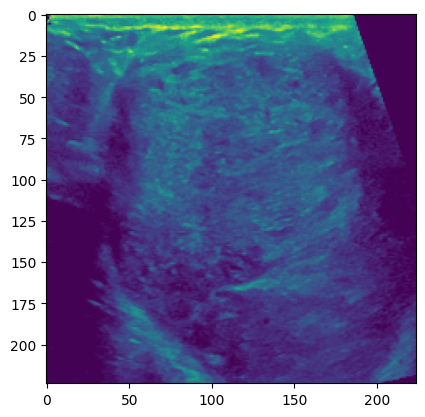

In [ ]:
plot.imshow(x[2])

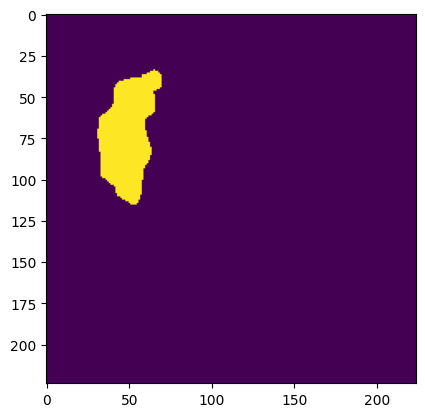

In [ ]:
plot.imshow(y[2])

Dividing Data into train and test sets

In [22]:
from sklearn.model_selection import train_test_split
xtr,xte,ytr,yte = train_test_split(x,y,test_size=0.2)

In [23]:
from tensorflow import keras

In [24]:
#DICE METRIC
def dice_metric(y_true, y_pred):
    y_true_f = tf.reshape(tf.dtypes.cast(y_true, tf.float32), [-1])
    y_pred_f = tf.reshape(tf.dtypes.cast(y_pred, tf.float32), [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return (2. * intersection + 1.) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + 1.)

In [25]:
inputs = keras.layers.Input((224,224,1))

# Convolution + Max Pooling

conv1 = keras.layers.Conv2D(32,2,padding='same',activation='relu')(inputs)
conv11 = keras.layers.Conv2D(32,2,padding='same',activation='relu')(conv1)
pool1 = keras.layers.MaxPool2D((2,2))(conv11)

# Convolution + Max Pooling
conv2 =  keras.layers.Conv2D(64,3,padding='same',activation='relu')(pool1)
conv21 =  keras.layers.Conv2D(64,3,padding='same',activation='relu')(conv2)
pool2 = keras.layers.MaxPool2D((2,2))(conv21)

# Convolution + Max Pooling

conv3 =  keras.layers.Conv2D(128,3,padding='same',activation='relu')(pool2)
conv31 =  keras.layers.Conv2D(128,3,padding='same',activation='relu')(conv3)
pool3 = keras.layers.MaxPool2D((2,2))(conv31)

conv4 =  keras.layers.Conv2D(256,3,padding='same',activation='relu')(pool3)
conv41 =  keras.layers.Conv2D(256,3,padding='same',activation='relu')(conv4)
pool4 = keras.layers.MaxPool2D((2,2))(conv41)


upsample2 = keras.layers.UpSampling2D((2,2))(pool4)
#end
uconv2 =  keras.layers.Conv2D(256,3,padding='same',activation='relu')(upsample2)
merge2 = keras.layers.Concatenate()([conv41,uconv2])
uconv21 =  keras.layers.Conv2D(256,3,padding='same',activation='relu')(merge2)
upsample3 = keras.layers.UpSampling2D((2,2))(uconv21)

uconv3 =  keras.layers.Conv2D(128,3,padding='same',activation='relu')(upsample3)
merge3 = keras.layers.Concatenate()([conv31,uconv3])
uconv31 =  keras.layers.Conv2D(128,3,padding='same',activation='relu')(merge3)

upsample4 = keras.layers.UpSampling2D((2,2))(uconv31)

uconv4=  keras.layers.Conv2D(64,3,padding='same',activation='relu')(upsample4)
merge4 = keras.layers.Concatenate()([conv21,uconv4])
uconv41 =  keras.layers.Conv2D(64,3,padding='same',activation='relu')(merge4)

upsample5 = keras.layers.UpSampling2D((2,2))(uconv41)

uconv5=  keras.layers.Conv2D(32,3,padding='same',activation='relu')(upsample5)
merge5 = keras.layers.Concatenate()([conv11,uconv5])
uconv51 =  keras.layers.Conv2D(32,3,padding='same',activation='relu')(merge5)


output =  keras.layers.Conv2D(1,1,padding='same',activation='sigmoid')(uconv51)

unet = keras.models.Model(inputs=inputs,outputs=output)
unet.compile(
    optimizer = 'adam',
    metrics = [dice_metric],
    loss='binary_focal_crossentropy'
)
unet.fit(xtr,ytr,epochs=100,validation_data=(xte,yte))

Epoch 1/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 19s 19s/step - dice_metric: 0.1175 - loss: 0.1593 - val_dice_metric: 0.0963 - val_loss: 0.1253
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step - dice_metric: 0.1192 - loss: 0.1228 - val_dice_metric: 0.0283 - val_loss: 0.1889
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 17s 17s/step - dice_metric: 0.0813 - loss: 0.1561 - val_dice_metric: 0.0914 - val_loss: 0.0928
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step - dice_metric: 0.1213 - loss: 0.0900 - val_dice_metric: 0.0937 - val_loss: 0.0996
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step - dice_metric: 0.1215 - loss: 0.0964 - val_dice_metric: 0.0930 - val_loss: 0.0939
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 19s 19s/step - dice_metric: 0.1219 - loss: 0.0906 - val_dice_metric: 0.0906 - val_loss: 0.0837
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 21s 21s/step - dice_metric: 0.1225 - loss: 0.0803 - val_dice_metric: 0.0844 - val_loss: 0.0754
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 21s 21s/step - dice_metric: 0.1220 - lo

In [27]:
unet.evaluate(xte,yte)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 738ms/step - dice_metric: 0.1690 - loss: 0.0500


[0.05001887306571007, 0.1690310537815094]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


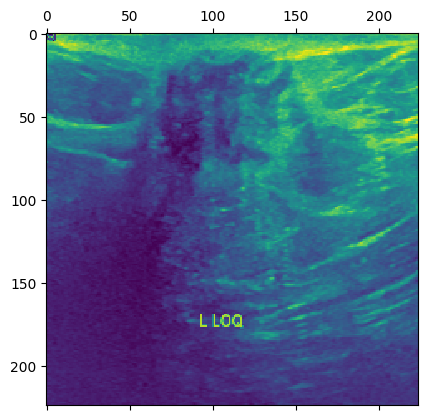

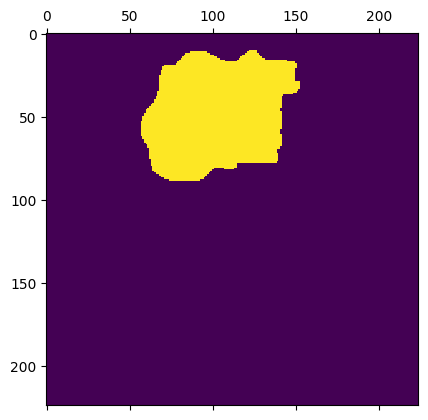

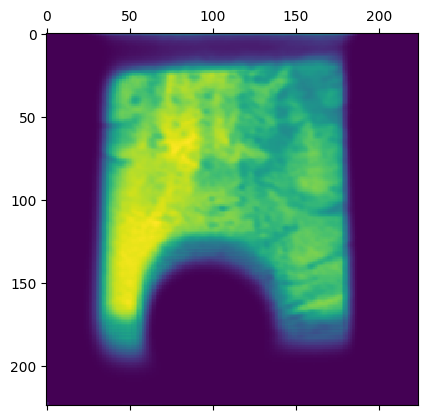

In [28]:
def plot_test(index,categorical=False):
  plot.matshow(xte[index])
  yp = unet.predict(xte[index].reshape(1,224,224))
  plot.matshow(yte[index])
  plot.matshow(yp.reshape(224,224))

plot_test(0)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 717ms/step


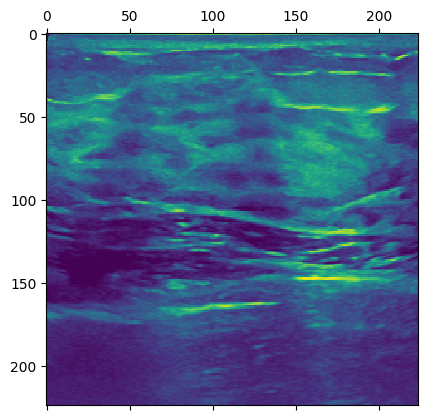

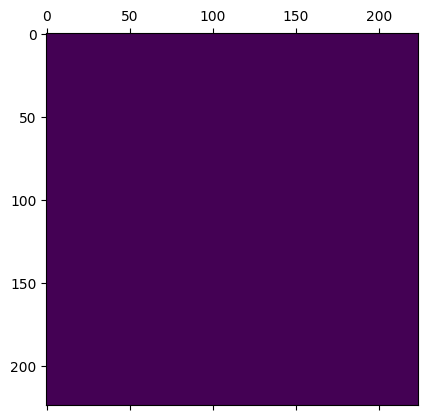

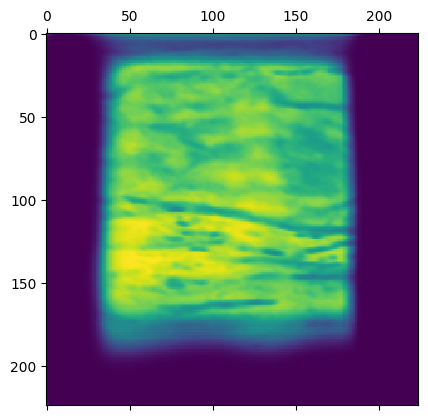

In [29]:
plot_test(1)

**ROC**

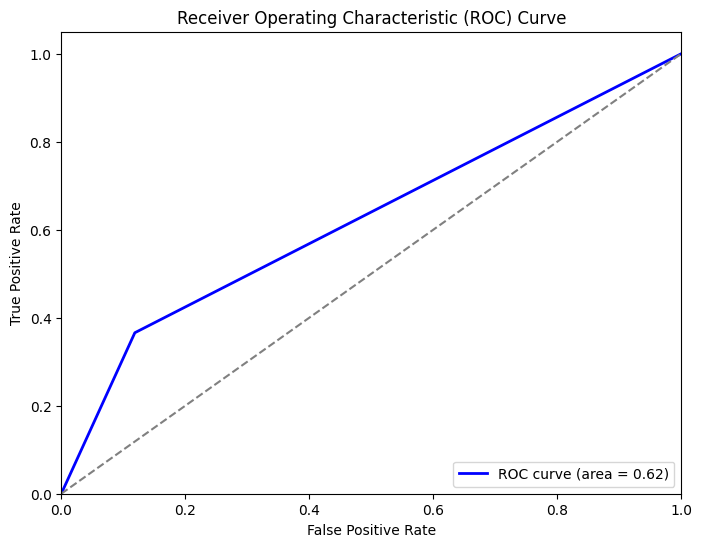

In [30]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np # Added for sample data creation


Y_train = np.random.randint(0, 2, size=100)
X_train = np.random.rand(100, 10)
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
model.fit(X_train,Y_train)

# Get predictions and true labels
y_true = Y_train.flatten()  # Flatten ground truth masks
y_pred = model.predict(X_train).flatten()  # Flatten predicted masks

# Compute ROC curve
fpr, tpr, _ = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

**Histogram**

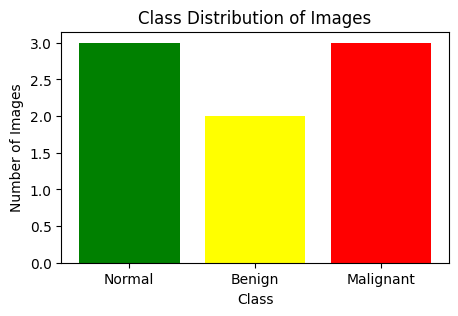

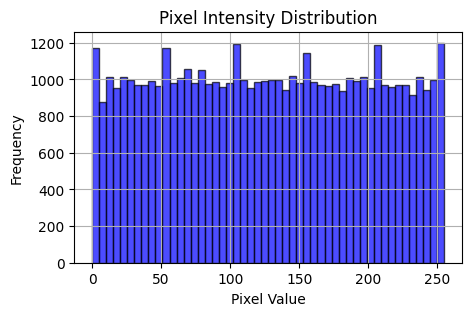

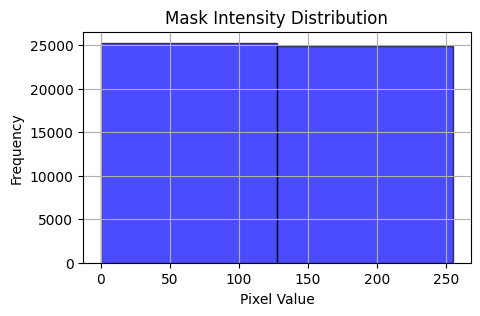

In [34]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

# Function to generate and display compact histograms
def plot_compact_histogram(data, title, xlabel, ylabel, bins=50):
    plt.figure(figsize=(5, 3))  # Smaller figure size for compact display
    plt.hist(data, bins=bins, color='blue', alpha=0.7, edgecolor='black')
    plt.title(title, fontsize=12)
    plt.xlabel(xlabel, fontsize=10)
    plt.ylabel(ylabel, fontsize=10)
    plt.grid(True)
    plt.show()

# Simulated dataset counts based on extracted code
num_malignant = 3
num_benign = 2
num_normal = 3

# Class Distribution Histogram
class_counts = [num_normal, num_benign, num_malignant]
class_labels = ["Normal", "Benign", "Malignant"]
plt.figure(figsize=(5, 3))
plt.bar(class_labels, class_counts, color=['green', 'yellow', 'red'])
plt.title("Class Distribution of Images", fontsize=12)
plt.xlabel("Class", fontsize=10)
plt.ylabel("Number of Images", fontsize=10)
plt.show()

# Simulated grayscale image data (random for now)
sample_image = np.random.randint(0, 256, (224, 224), dtype=np.uint8)

# Pixel Intensity Histogram for a sample image
plot_compact_histogram(sample_image.ravel(), "Pixel Intensity Distribution", "Pixel Value", "Frequency")

# Simulated mask image (binarized mask, only 0 and 255)
sample_mask = np.random.choice([0, 255], size=(224, 224), p=[0.5, 0.5]).astype(np.uint8)

# Mask Intensity Histogram
plot_compact_histogram(sample_mask.ravel(), "Mask Intensity Distribution", "Pixel Value", "Frequency", bins=2)